In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
from tensorflow import keras

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [6]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# New Train

In [7]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    
    tf.keras.layers.LSTM(64),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1150      
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 128)           19328     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 64)            16448     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

# 1. Make Data X_train, y_train, X_test, y_test

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [9]:
# make DeepMSpeptide format
args = file_path + 'detect_peptide_train_noptm_largedata.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y_noptm_largedata.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm_largedata.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y_noptm_largedata.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


Loading input peptides
Succesfully loaded 421474 peptides and skipped 0
Loading input peptides
Succesfully loaded 88998 peptides and skipped 0
(337179, 30) (84295, 30) (88998, 30) (337179,) (84295,) (88998,)


# 2. train

In [10]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [11]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val),
                                       callbacks=[es])

Epoch 1/200
3372/3372 [==============================] - 137s 38ms/step - loss: 0.5069 - accuracy: 0.7269 - val_loss: 0.3798 - val_accuracy: 0.8221
Epoch 2/200
3372/3372 [==============================] - 127s 38ms/step - loss: 0.3829 - accuracy: 0.8200 - val_loss: 0.3740 - val_accuracy: 0.8264
Epoch 3/200
3372/3372 [==============================] - 127s 38ms/step - loss: 0.3662 - accuracy: 0.8306 - val_loss: 0.3488 - val_accuracy: 0.8406
Epoch 4/200
3372/3372 [==============================] - 126s 37ms/step - loss: 0.3533 - accuracy: 0.8390 - val_loss: 0.3415 - val_accuracy: 0.8460
Epoch 5/200
3372/3372 [==============================] - 127s 38ms/step - loss: 0.3478 - accuracy: 0.8417 - val_loss: 0.3417 - val_accuracy: 0.8450
Epoch 6/200
3372/3372 [==============================] - 126s 37ms/step - loss: 0.3462 - accuracy: 0.8431 - val_loss: 0.3385 - val_accuracy: 0.8479
Epoch 7/200
3372/3372 [==============================] - 127s 38ms/step - loss: 0.3427 - accuracy: 0.8455 - val_

3372/3372 [==============================] - 118s 35ms/step - loss: 0.3093 - accuracy: 0.8628 - val_loss: 0.3139 - val_accuracy: 0.8613
Epoch 57/200
3372/3372 [==============================] - 117s 35ms/step - loss: 0.3082 - accuracy: 0.8636 - val_loss: 0.3123 - val_accuracy: 0.8620
Epoch 58/200
3372/3372 [==============================] - 118s 35ms/step - loss: 0.3087 - accuracy: 0.8638 - val_loss: 0.3142 - val_accuracy: 0.8612
Epoch 59/200
3372/3372 [==============================] - 116s 34ms/step - loss: 0.3075 - accuracy: 0.8639 - val_loss: 0.3129 - val_accuracy: 0.8616
Epoch 60/200
3372/3372 [==============================] - 118s 35ms/step - loss: 0.3056 - accuracy: 0.8648 - val_loss: 0.3134 - val_accuracy: 0.8614
Epoch 61/200
3372/3372 [==============================] - 117s 35ms/step - loss: 0.3085 - accuracy: 0.8637 - val_loss: 0.3143 - val_accuracy: 0.8609
Epoch 62/200
3372/3372 [==============================] - 117s 35ms/step - loss: 0.3052 - accuracy: 0.8656 - val_loss: 

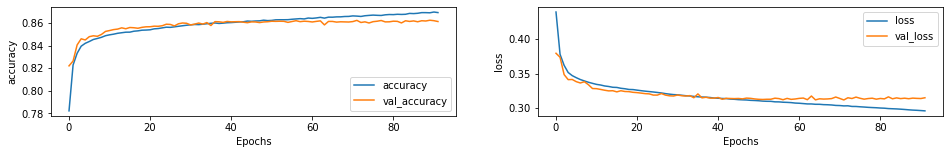

In [12]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

2782/2782 [==============================] - 53s 19ms/step - loss: 0.3063 - accuracy: 0.8677
Test Loss: 0.3063461482524872
Test Accuracy: 0.8676599264144897


              precision    recall  f1-score   support

           0       0.91      0.82      0.86     44509
           1       0.83      0.92      0.87     44489

    accuracy                           0.87     88998
   macro avg       0.87      0.87      0.87     88998
weighted avg       0.87      0.87      0.87     88998

rf auc : 0.9438127149446225


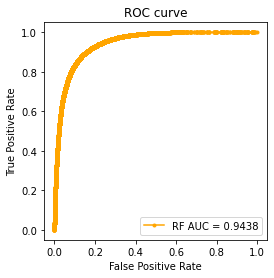

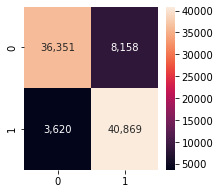

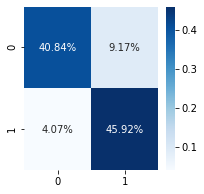

In [15]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()